In [1]:
import scanpy as sc, numpy as np, pandas as pd
import scvi
import pymde

/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/pymde/functions/losses.py:1: SyntaxWarning: invalid escape sequence '\d'
  """Losses: distortion functions derived from original deviations.
/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/pymde/functions/losses.py:102: 

In [2]:
adata_merged = sc.read_h5ad('./adata_merged.pp1.v250501.h5ad')

In [4]:
stress_genes = ["JUN","JUNB","JUND", "FOS","FOSB","FOSL2", "HSP90AA1","HSP90AB1","HSPA1A","HSPA1B","HSPA5","HSPA8","HSPB1"]
mt_genes = adata_merged.var[adata_merged.var.index.str.startswith('MT-')].index.tolist()
sex_genes = ['SRY','RPS4Y1','KDM5D','DDX3Y','UTY','ZFY',
             'XIST','TSIX','KDM6A', 'EIF2S3X']
cell_cycle_genes = [
    "MCM5","PCNA","TYMS","FEN1","MCM2","MCM4","RRM1","UNG","GINS2","MCM6","CDCA7","DTL","PRIM1",
    "UHRF1","MLF1IP","HELLS","RFC2","RPA2","NASP","RAD51AP1","GMNN","WDR76","SLBP","CCNE2","UBR7",
    "POLD3","MSH2","ATAD2","RAD51","RRM2","CDC45","CDC6","EXO1","TIPIN","DSCC1","BLM","CASP8AP2",
    "USP1","CLSPN","POLA1","CHAF1B","BRIP1","E2F8","HMGB2","CDK1","NUSAP1","UBE2C","BIRC5","TPX2",
    "TOP2A","NDC80","CKS2","NUF2","CKS1B","MKI67","TMPO","CENPF","TACC3","FAM64A","SMC4","CCNB2",
    "CKAP2L","CKAP2","AURKB","BUB1","KIF11","ANP32E","TUBB4B","GTSE1","KIF20B","HJURP","CDCA3",
    "HN1","CDC20","TTK","CDC25C","KIF2C","RANGAP1","NCAPD2","DLGAP5","CDCA2","CDCA8","ECT2","KIF23",
    "HMMR","AURKA","PSRC1","ANLN","LBR","CKAP5","CENPE","CTCF","NEK2","G2E3","GAS2L3","CBX5","CENPA"]

nuisance_genes = stress_genes + mt_genes + sex_genes + cell_cycle_genes
nuisance_genes = [g for g in nuisance_genes if g in adata_merged.var_names]

In [5]:
# put nuisances to .obs as a nuisance factor
for g in nuisance_genes:
    exp = np.array(adata_merged[:,g].X.todense()).reshape([-1])
    adata_merged.obs[g] = exp.copy()

# remove the nuisance genes from the anndata
gene_subset = [g for g in adata_merged.var_names if g not in nuisance_genes]
adata_merged = adata_merged[:,gene_subset].copy()

/tmp/ipykernel_18188/3610507784.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata_merged.obs[g] = exp.copy()
/tmp/ipykernel_18188/3610507784.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata_merged.obs[g] = exp.copy()
/tmp/ipykernel_18188/3610507784.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

In [7]:
sc.pp.highly_variable_genes(adata_merged, batch_key='sample', n_top_genes=1000)

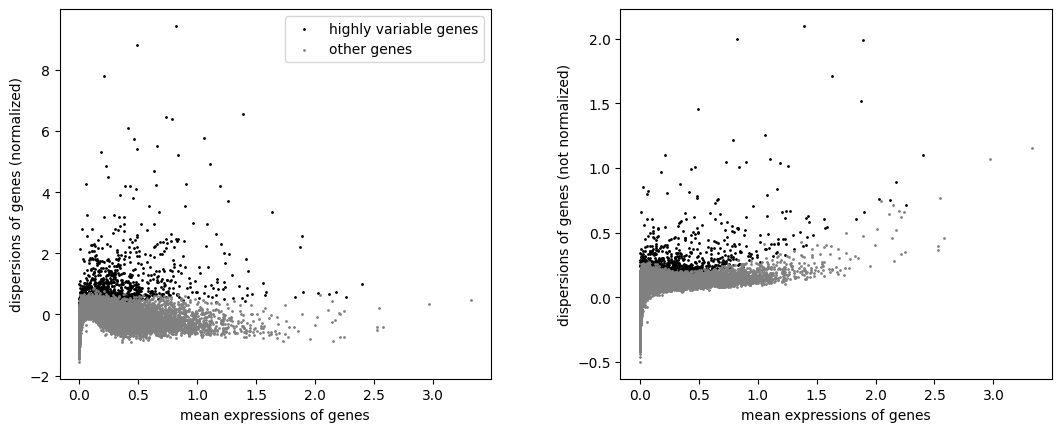

In [8]:
sc.pl.highly_variable_genes(adata_merged)

In [9]:
scvi.model.SCVI.setup_anndata(
    adata_merged, layer="counts",
    batch_key='pool',
    categorical_covariate_keys = ["background", "pool"],
    continuous_covariate_keys  = ["pct_counts_mt", "log1p_n_genes_by_counts", 'log1p_total_counts'] + nuisance_genes,
)

model = scvi.model.SCVI(adata_merged, n_hidden=128, n_latent=30, n_layers=2)

In [11]:
model.train(max_epochs=60)


/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /share/software/user/open/py-jupyterlab/4.3.2_py312 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /share/software/user/open/py-jupyterlab/4.3.2_py312 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dat

Epoch 60/60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [07:45<00:00,  7.64s/it, v_num=1, train_loss_step=7.57e+3, train_loss_epoch=7.85e+3]

`Trainer.fit` stopped: `max_epochs=60` reached.



poch 60/60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [07:45<00:00,  7.76s/it, v_num=1, train_loss_step=7.57e+3, train_loss_epoch=7.85e+3]

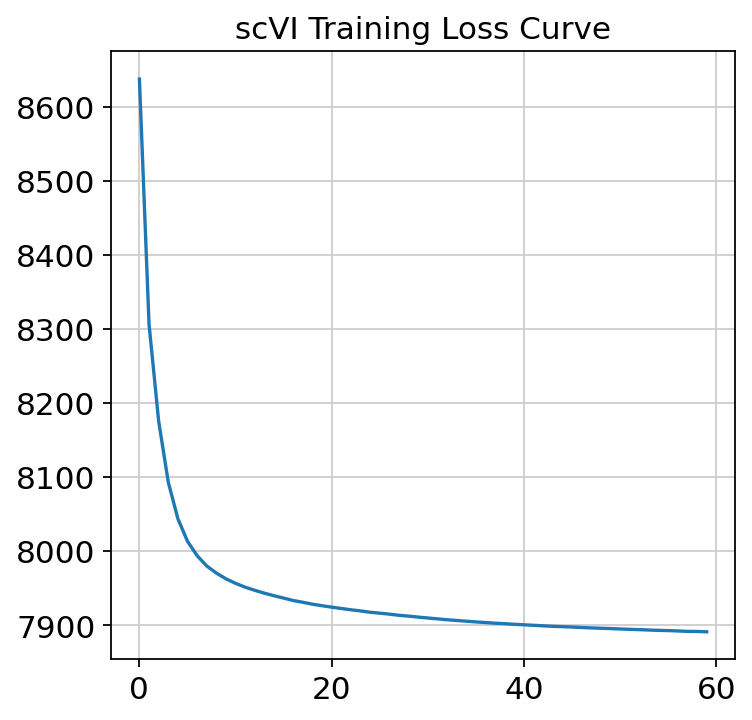

In [12]:
import matplotlib.pyplot as plt
sc.set_figure_params(figsize=[5,5])
plt.plot(model.history['elbo_train'], label='ELBO Train')
plt.title('scVI Training Loss Curve')
plt.show()

In [13]:
adata_merged.obsm['X_scvi'] = model.get_latent_representation()

In [14]:
embedder = pymde.preserve_neighbors(adata_merged.obsm['X_scvi'], verbose=False, device='cuda', repulsive_fraction=0.5)
embedding = embedder.embed(verbose=False)
adata_merged.obsm['X_vimde'] =  embedding.detach().cpu().numpy()

In [15]:
model.save('scvi-model-250501',overwrite=True)

In [16]:
adata_merged.write_h5ad('adata_merged.250501.h5ad')

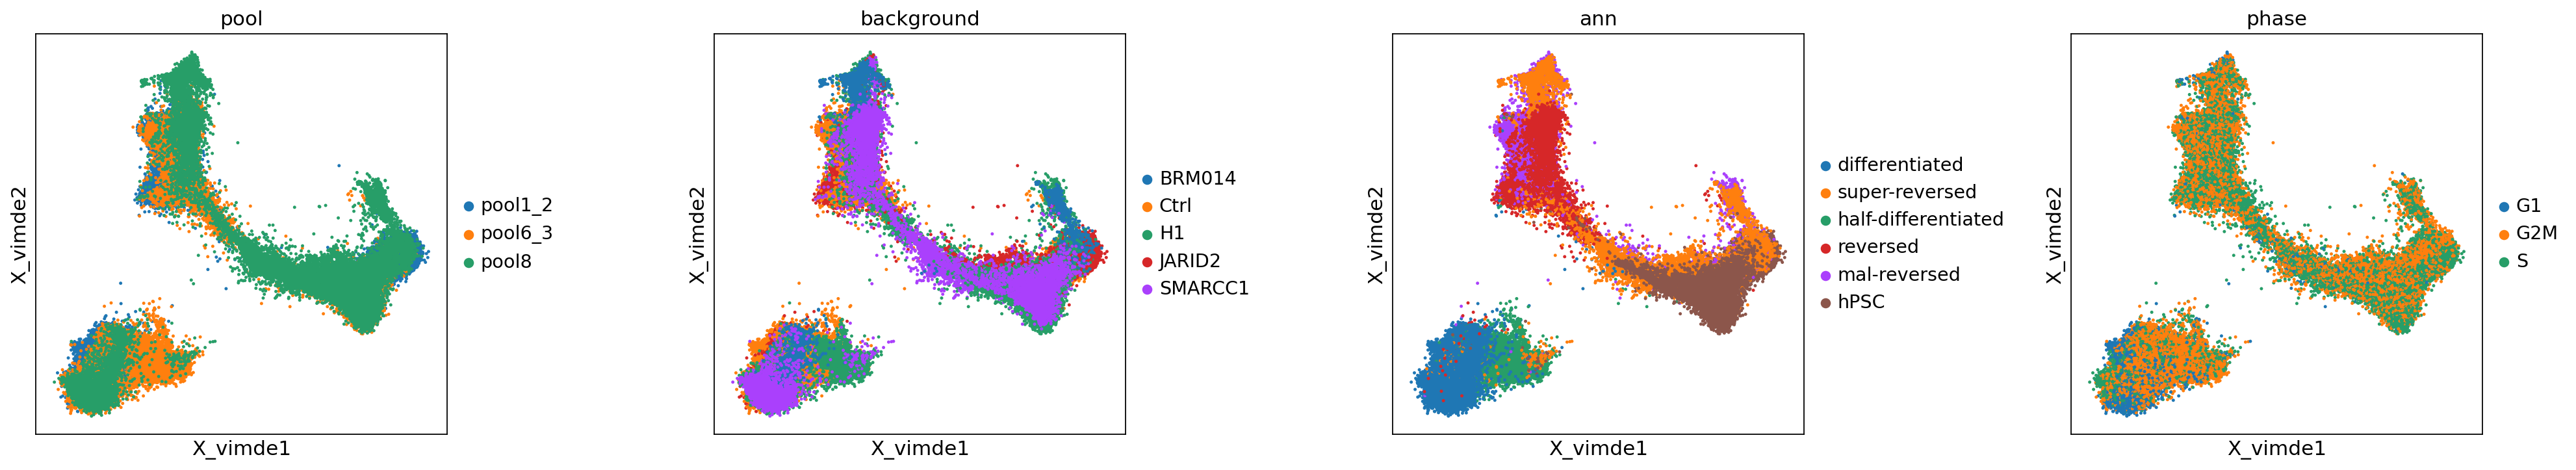

In [17]:
sc.pl.embedding(adata_merged, basis= 'X_vimde', wspace=0.5, color=['pool','background','ann','phase'],size=20)